# Dataset preparation

In [1]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import numpy as np

from pyarrow import Table
from pandas import DataFrame, api, Int64Dtype
from pandas.core.dtypes import common as com
import sys
sys.path.append('..')
from utils.preprocess import NDF

def cast_timestamp(df: DataFrame):
    """
    Cast timestamp fields to seconds since epoch.
    """
    for col in df.columns:
        if com.is_timedelta64_dtype(df[col]):
            df[col] = df[col].dt.total_seconds()  # This converts timedelta to float (seconds)
        elif com.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(np.int64) // 10**9  # Converts datetime64 to Unix timestamp (seconds)

    return df


def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

##################################
# EDIT to specify the model name #
##################################
model_name = "malware_cesnet"     
##################################

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    '../feature-extraction/floor/benign_2312.parquet',
    '../feature-extraction/floor/umbrella_benign_FINISHED.parquet'
]
malicious_dataset_filenames = [
    '../feature-extraction/floor/phishing_final_2024.parquet',
]
# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "phishing"
# #############################################################

# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]

malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}

# Merge them together and create NDF

# Store them for future use (e.g. creating NDF)
df_benign.to_parquet('temp/benign_merged.parquet')
df_malicious.to_parquet('temp/malicious_merged.parquet')

from utils.preprocess import NDF
input_data = {
    'benign': 'temp/benign_merged.parquet',
    'malign': 'temp/malicious_merged.parquet'
}
ndf_dataset = NDF("phishing", True, input_data=input_data, one_line_processing=False)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2024-06-04 16:28:17,730 - utils.preprocess - INFO - Benign dataset path: temp/benign_merged.parquet
2024-06-04 16:28:17,731 - utils.preprocess - INFO - Malign dataset path: temp/malicious_merged.parquet
2024-06-04 16:28:18,286 - utils.preprocess - INFO - Number of records in combined dataset: 1001591
2024-06-04 16:29:12,451 - utils.preprocess - INFO - Decision tree model saved to models/decision_tree_model.joblib
2024-06-04 16:29:13,577 - utils.preprocess - INFO - New feature 'dtree_prob' created from decision tree predictions.
2024-06-04 16:29:15,843 - utils.preprocess - INFO - Decision Tree Train Accuracy: 0.97
2024-06-04 16:29:15,844 - utils.preprocess - INFO - Decision Tree Test Accuracy: 0.96
2024-06-04 16:31:17,611 - utils.preprocess - INFO - Decision Tree Cross-Validation Scores: [0.95665301 0.95597609 0.95644022]
2024-06-04 16:31:17,855 - utils.preprocess - I


Dataset Subset:
Name: dataset_temp/maliciousmerged_2024-06-04.parquet
Features:
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0  -0.319993   2.733996  -0.424121  -0.516387  -0.735418  -0.439875   
1  -0.319993   0.864734   1.776367  -0.516387   0.531789  -0.439875   
2  -0.319993  -0.069896   0.676123  -0.516387  -0.735418  -0.439875   
3  -0.319993   0.864734   1.776367  -0.516387  -0.735418  -0.439875   
4  -0.319993  -0.069896  -0.424121  -0.516387  -0.735418  -0.439875   
5  -0.319993  -0.069896  -0.424121  -0.516387  -0.735418  -0.439875   
6  -0.319993  -1.004527  -0.424121  -0.516387  -0.735418  -0.439875   
7  -0.319993  -0.069896  -0.424121  -0.516387  -0.735418  -0.439875   
8  -0.319993  -1.004527  -0.424121  -0.516387  -0.735418  -0.439875   
9  -0.319993  -0.069896  -0.424121  -0.516387  -0.735418  -0.439875   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_161  Feature_162  \
0  -0.851905  -0.504423  -0.294592  -0.247121  ...    -0.

In [6]:
# Convert the unique feature names to a list
#feature_names_list = ndf_dataset['feature_names'].unique().tolist()

# Print each feature name individually
#for feature in feature_names_list:
#    print(feature)

for feature_name in ndf_dataset['feature_names']:
    print(feature_name)

dns_has_dnskey
dns_A_count
dns_AAAA_count
dns_MX_count
dns_NS_count
dns_TXT_count
dns_SOA_count
dns_CNAME_count
dns_zone_level
dns_zone_digit_count
dns_zone_len
dns_zone_entropy
dns_resolved_record_types
dns_dnssec_score
dns_ttl_avg
dns_ttl_stdev
dns_ttl_low
dns_ttl_mid
dns_ttl_distinct_count
dns_soa_primary_ns_level
dns_soa_primary_ns_digit_count
dns_soa_primary_ns_len
dns_soa_primary_ns_entropy
dns_soa_email_level
dns_soa_email_digit_count
dns_soa_email_len
dns_soa_email_entropy
dns_soa_refresh
dns_soa_retry
dns_soa_expire
dns_soa_min_ttl
dns_domain_name_in_mx
dns_mx_avg_len
dns_mx_avg_entropy
dns_txt_avg_len
dns_txt_avg_entropy
dns_txt_external_verification_score
dns_txt_spf_exists
dns_txt_dkim_exists
dns_txt_dmarc_exists
ip_count
ip_mean_average_rtt
ip_v4_ratio
ip_a_aaaa_to_all_ratio
ip_entropy
ip_as_address_entropy
ip_asn_entropy
ip_distinct_as_count
tls_has_tls
tls_chain_len
tls_is_self_signed
tls_negotiated_version_id
tls_negotiated_cipher_id
tls_root_cert_validity_len
tls_leaf_

# Model validation function

In [13]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, log_loss, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Helpers
from kneed import KneeLocator

def plot_metric(metric):
    plt.rcParams["figure.dpi"] = 300
    
    # Plot metric curves
    plt.plot(x_axis, results['training'][metric], label='Training set')
    plt.plot(x_axis, results['valid_1'][metric], label='Testing set')
    
    # Detect elbow using Kneedle algorithm
    kn = KneeLocator(x_axis, results['valid_1'][metric], curve='convex', direction='decreasing')
    if kn.knee:
        plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Elbow at tree ' + str(kn.knee))
    
    plt.legend()
    mnames = {'error': 'Classification Error', 'binary_logloss': 'Log Loss', 'auc': 'AUC'}
    mname = mnames.get(metric, metric)  # Return the metric itself if it's not in the dictionary
    plt.ylabel(mname)
    plt.xlabel('Number of trees')
    plt.title('LightGBM ' + mname)
    plt.show()

    
# Tuning - graphs
def DisplayTuningGraph(scores):
    from numpy import array
    from numpy.ma import masked_array

    col_names = ['mean_train_score', 'mean_test_score']
    means_df = scores[col_names]
    ax = means_df.plot(kind='line', grid=True)

    from matplotlib import pyplot as plt
    plt.rcParams["figure.figsize"] = [12, 12]
    plt.rcParams["figure.autolayout"] = True

    plt.rcParams["figure.dpi"] = 300

    max_ids = means_df.idxmax(axis=0)

    for i in range(len(max_ids)):
        for col_name in col_names:
            value = means_df[col_name][max_ids[i]]
            id = max_ids[i]

            color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'

            ax.scatter([id], [value],
                      marker='o',
                      color=color,
                      label='point',)

            ax.annotate(str(round(value, 3))+"_ID="+str(id),
                        (id, value),
                        xytext=(id+3, value))
    print(scores)

def ValidateModel_advanced(X_test, y_test, model): 
    y_pred = model.predict(X_test)
    
    # Classification report
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    tn, fp, fn, tp = cm.ravel()
    print("Confusion Matrix:")
    print("TN:", tn, "FP:", fp, "FN:", fn, "TP:", tp)

    # Plotting ROC Curve
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Model-specific evaluations
    if isinstance(model, (XGBClassifier, LGBMClassifier)):
        
        if isinstance(model, (XGBClassifier)):
            results = model.evals_result()
        elif isinstance(model, (LGBMClassifier)):
            results = model.evals_result_

        training_key = 'training' if isinstance(model, LGBMClassifier) else 'validation_0'
        validation_key = 'valid_1' if isinstance(model, LGBMClassifier) else 'validation_1'
        
        print("Training metrics:", results[training_key].keys())
        print("Validation metrics:", results[validation_key].keys())

        trees = len(results[validation_key]['binary_logloss']) if isinstance(model, LGBMClassifier) else len(results[validation_key]['logloss'])
        x_axis = range(0, trees)

        def plot_metric(metric):
            plt.rcParams["figure.dpi"] = 300

            # Plot metric curves
            plt.plot(x_axis, results[training_key][metric], label='Training set')
            plt.plot(x_axis, results[validation_key][metric], label='Validation set')

            # Detect elbow using Kneedle algorithm
            kn = KneeLocator(x_axis, results[validation_key][metric], curve='convex', direction='decreasing')
            if kn.knee:
                plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Elbow at tree ' + str(kn.knee))

            plt.legend()
            mnames = {'binary_logloss': 'Log Loss', 'auc': 'AUC'}
            mname = mnames.get(metric, metric)
            plt.ylabel(mname)
            plt.xlabel('Number of trees')
            plt.title(f'{type(model).__name__} {mname}')
            plt.show()

        if isinstance(model, LGBMClassifier):
            plot_metric('binary_logloss')
        elif isinstance(model, XGBClassifier):
            plot_metric('logloss')
            
        plot_metric('auc')
        
    elif isinstance(model, (RandomForestClassifier, AdaBoostClassifier)):
        # For RandomForest and AdaBoost, additional model-specific evaluations can be added here
        pass
    
    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)  # Compute confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)  # Create display object
    disp.plot(cmap=plt.cm.Blues)  # Plot confusion matrix
    plt.show()  # Show the plot

# NDF-based LightGBM

In [14]:
# Check if the NDF contains corresponding number of classes

# Assuming ndf_dataset is a DataFrame with 'features' and 'labels' columns
X = np.array(ndf_dataset['features'].tolist())
Y = np.array(ndf_dataset['labels'].tolist())

# Check unique values in labels
unique_labels = np.unique(Y)
print(f"Unique labels: {unique_labels}")

# Ensure binary classification
assert len(unique_labels) == 2, "The problem is not binary classification."

Unique labels: [0. 1.]


In [15]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module="sklearn")

X_train, X_test, Y_train, Y_test = train_test_split(  
  np.array(ndf_dataset['features']),
  np.array(ndf_dataset['labels']),
  test_size=0.2,
  random_state=42
)

## LightGBM NDF-based model Training

In [16]:
import joblib
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# LightGBM parameters
params = {
    "objective": "binary",  # binary classification
    "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
    "n_estimators": 897, # Number of boosted trees to fit, equivalent to number of boosting iterations
    "num_leaves": 59,
    "max_depth": 17,
    "learning_rate": 0.15,
    "objective": "binary",
    "min_child_samples": 27,
    "colsample_bytree": 0.9,
    "reg_lambda": 0.11,
    "scale_pos_weight": 4.4864,
    "subsample_for_bin": 240000,
    "random_state": 7,
}


model = lgb.LGBMClassifier(**params, metric=['error', 'binary_logloss', 'auc'])

# at last, train the model
eval_set = [(X_train, Y_train), (X_test, Y_test)]
_ = model.fit(X_train, Y_train, eval_set=eval_set)

# Save the model to a file
joblib.dump(model, 'models/phishing_lgbm_model.joblib')

[LightGBM] [Info] Number of positive: 128718, number of negative: 600133
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15184
[LightGBM] [Info] Number of data points in the train set: 728851, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176604 -> initscore=-1.539527
[LightGBM] [Info] Start training from score -1.539527


['models/phishing_lgbm_model.joblib']

## LightGBM NDF-based model Validation

              precision    recall  f1-score   support

         0.0     0.9958    0.9967    0.9962    150292
         1.0     0.9842    0.9803    0.9822     31921

    accuracy                         0.9938    182213
   macro avg     0.9900    0.9885    0.9892    182213
weighted avg     0.9938    0.9938    0.9938    182213

Confusion Matrix:
TN: 149789 FP: 503 FN: 630 TP: 31291


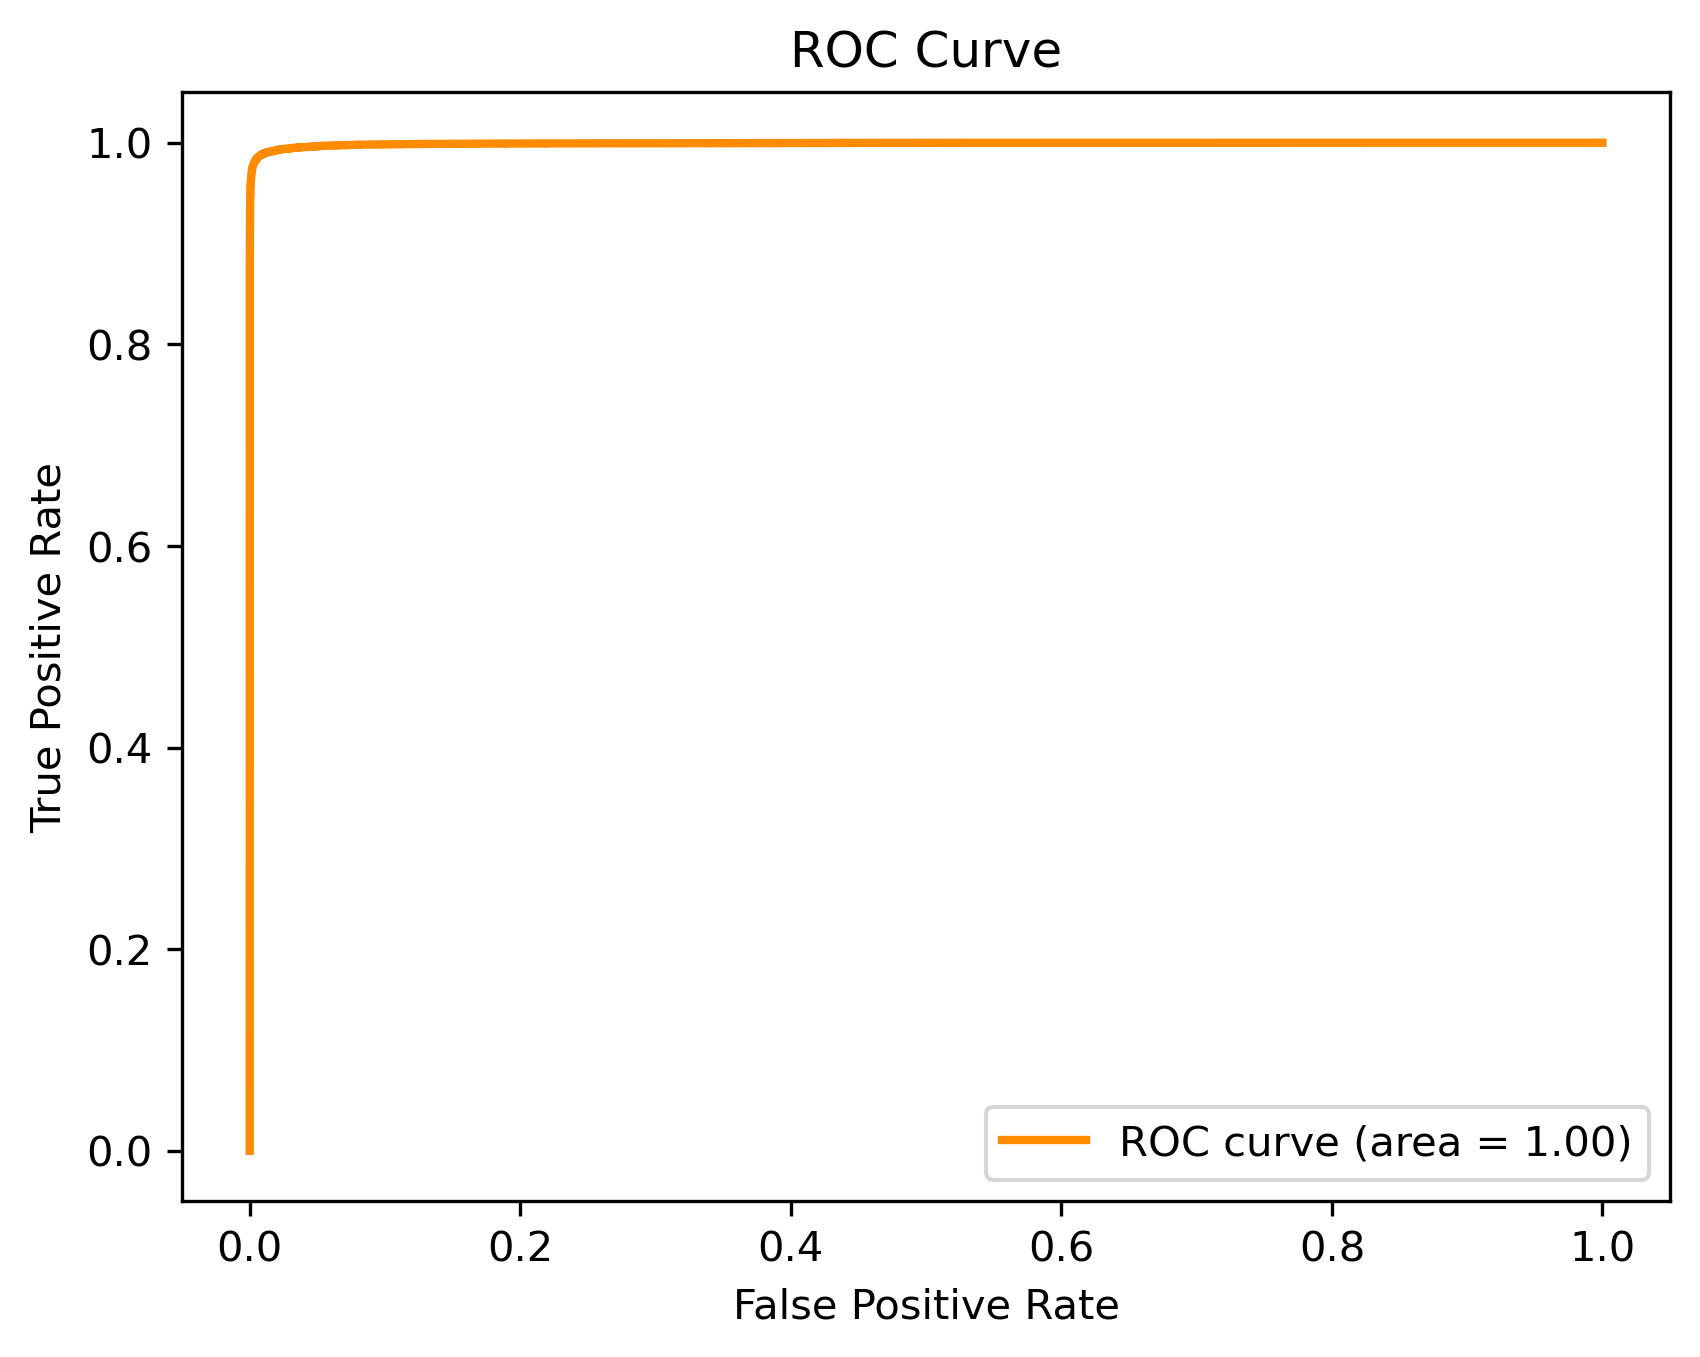

Training metrics: odict_keys(['binary_logloss', 'auc'])
Validation metrics: odict_keys(['binary_logloss', 'auc'])


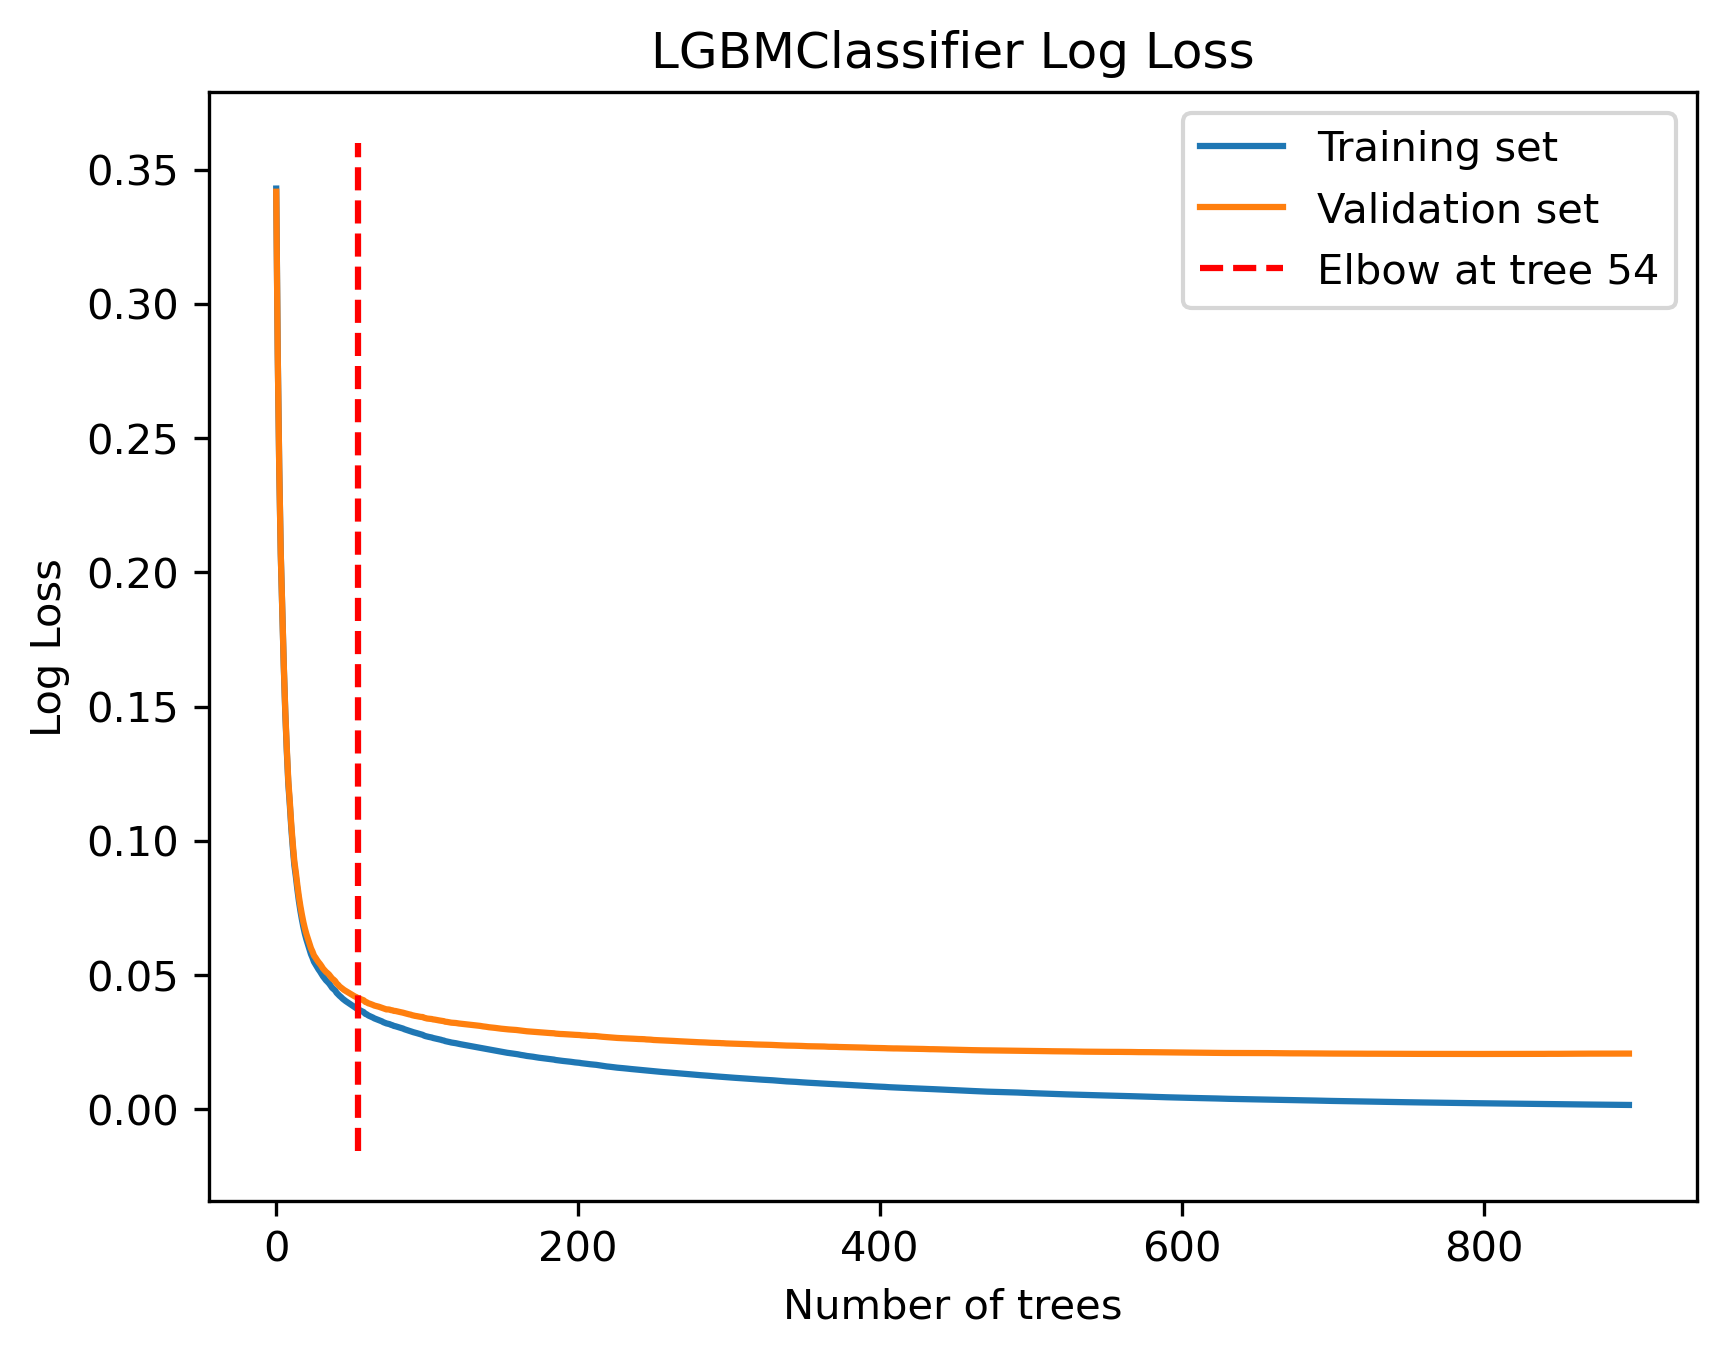

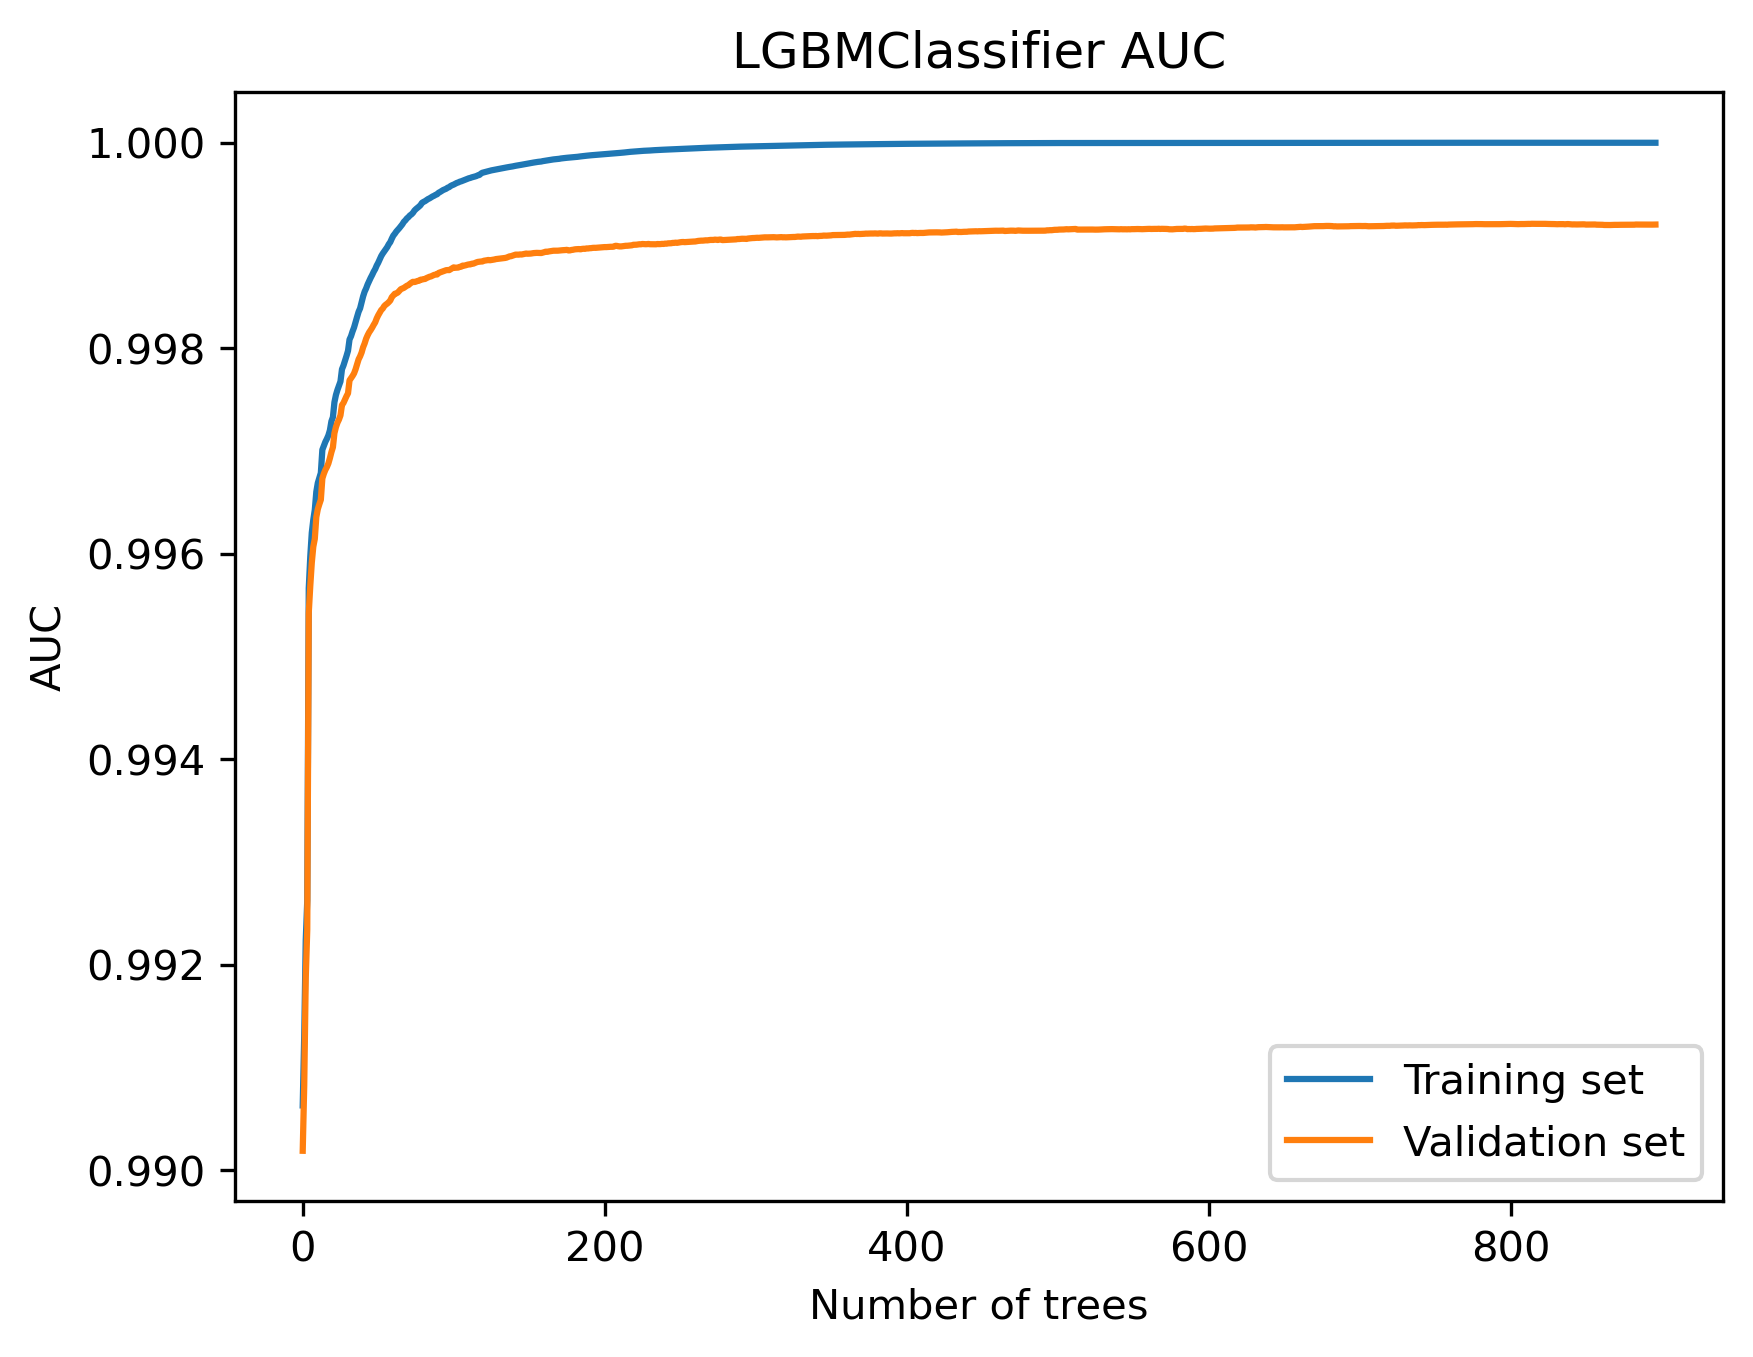

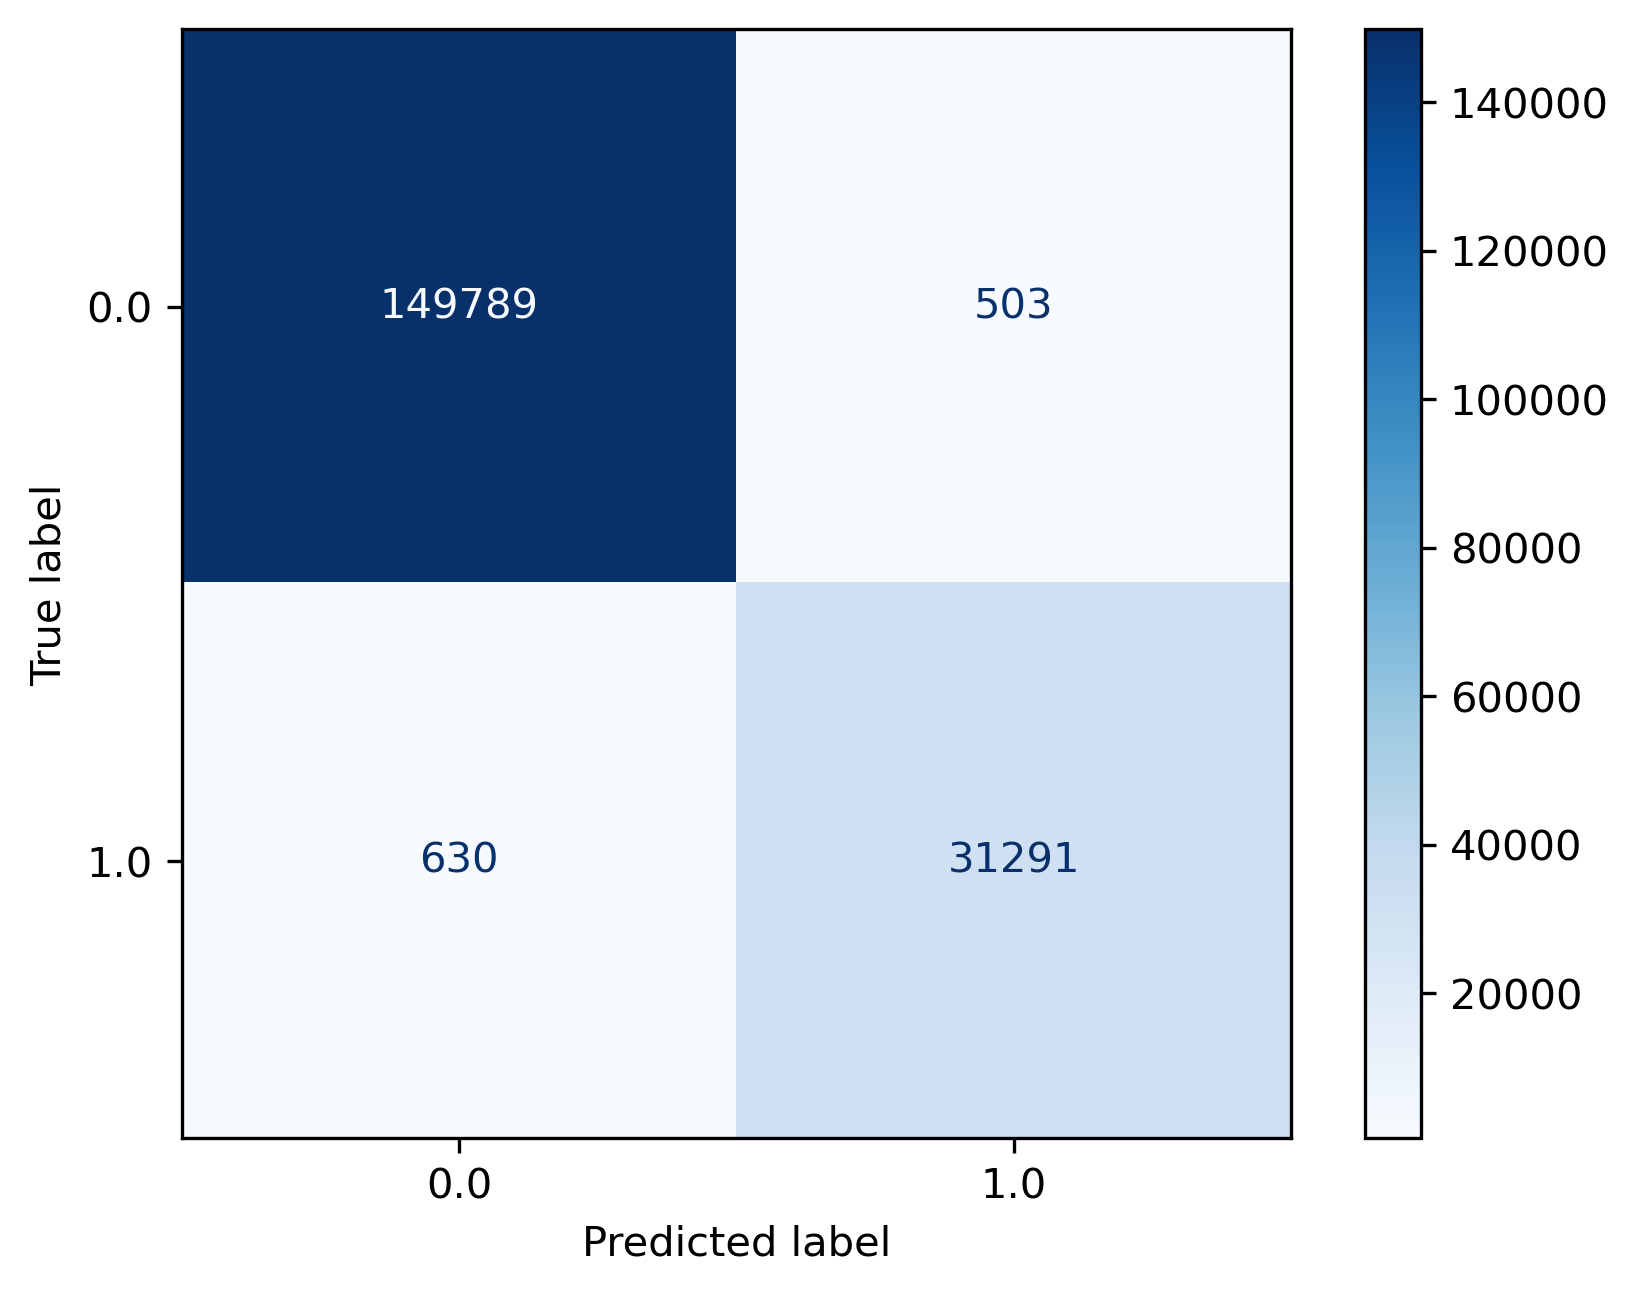

In [17]:
ValidateModel_advanced(X_test, Y_test, model)

## LightGBM model Tuning

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, log_loss

def FETA_Score(estimator, X, y):
    # Getting predictions
    y_pred = estimator.predict(X)
    y_pred_proba = estimator.predict_proba(X)
    
    # Calculating precision
    precision = precision_score(y, y_pred)
    
    # Calculating recall
    recall = recall_score(y, y_pred)
    
    # Calculating F1-score
    f1 = f1_score(y, y_pred)
    
    # Calculating FPR
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # Calculating Log Loss
    logloss = log_loss(y, y_pred_proba)
    
    # Estimating overfitting
    train_score = estimator.score(X_train, y_train) 
    validation_score = estimator.score(X, y) 
    overfitting = train_score - validation_score
    
    # Assigning weights
    w_precision = 0.1     # Precision
    w_recall = 0.1        # Recall
    w_f1 = 0.6            # F1
    w_fpr = -0.0          # Negative because lower FPR is better
    w_logloss = -0.0      # Negative because lower log loss is better
    w_overfitting = -0.2  # Negative because lower overfitting is better
    
    #w_precision = 0.0     # Precision
    #w_recall = 0.5        # Recall
    #w_f1 = 0.5            # F1
    #w_fpr = -0.0          # Negative because lower FPR is better
    #w_logloss = -0.1      # Negative because lower log loss is better
    #w_overfitting = -0.0  # Negative because lower overfitting is better
    
    # Assigning weights
    #w_precision = 0.1     # Precision
    #w_recall = 0.1        # Recall
    #w_f1 = 0.4            # F1
    #w_fpr = -0.1          # Negative because lower FPR is better
    #w_logloss = -0.1      # Negative because lower log loss is better
    #w_overfitting = -0.5  # Negative because lower overfitting is better
    
    # Combining metrics with weights
    combined_score = (w_precision * precision + w_recall * recall + w_f1 * f1 + w_fpr * fpr + w_overfitting * overfitting)
    
    return combined_score


In [22]:
lgbm_tuning = True

if lgbm_tuning:
    import pandas as pd
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import StratifiedKFold
    from lightgbm import LGBMClassifier  # Updated import

    params = {
        "objective": "binary",  # binary classification
        "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
        "n_estimators": 897, # Number of boosted trees to fit, equivalent to number of boosting iterations
        "num_leaves": 59,
        "max_depth": 17,
        "learning_rate": 0.15,
        "objective": "binary",
        "min_child_samples": 27,
        "colsample_bytree": 0.9,
        "reg_lambda": 0.11,
        #"scale_pos_weight": 1.1, # default: 1.0
        "scale_pos_weight": 4.4864,
        "subsample_for_bin": 240000,
        "random_state": 7,
    }

    clf = LGBMClassifier(**params)  # Updated classifier instantiation

    # this is your grid of parameters to search through, every combination will be tried
    grid = {
        "n_estimators": [600, 700, 800],
        "max_depth": [10, 12, 14, 16, 18],
        #"n_estimators": [897],
        #"num_leaves": [59],
        #"max_depth": [20],
        #"learning_rate": [0.11, 0.12, 0.13, 0.2],
        #'scale_pos_weight': [1.7, 1.8, 1.9],
        #"subsample": [0.1],
        #reg_lambda": [0.1],
        #'min_split_gain' : [0.0, 0.1, 0.2]
        #'subsample_for_bin': [215000, 220000, 230000, 240000],
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=grid,
        #n_jobs=-1,
        cv=cv,
        #scoring='neg_log_loss',
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, Y_train)

    clf = grid_search.best_estimator_

    scores = pd.DataFrame(grid_search.cv_results_)
    col_names = ['mean_train_score', 'mean_test_score']

    scores = pd.DataFrame(grid_search.cv_results_)



Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Info] Number of positive: 85812, number of negative: 400088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.197449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15142
[LightGBM] [Info] Number of data points in the train set: 485900, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176604 -> initscore=-1.539526
[LightGBM] [Info] Start training from score -1.539526
[CV 1/3] END max_depth=10, n_estimators=600;, score=(train=nan, test=nan) total time=  34.6s
[LightGBM] [Info] Number of positive: 85812, number of negative: 400089
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15112
[LightGBM] [Inf

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15112
[LightGBM] [Info] Number of data points in the train set: 485901, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176604 -> initscore=-1.539528
[LightGBM] [Info] Start training from score -1.539528
[CV 2/3] END max_depth=12, n_estimators=700;, score=(train=nan, test=nan) total time=  40.2s
[LightGBM] [Info] Number of positive: 85812, number of negative: 400089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15173
[LightGBM] [Info] Number of data points in the train set: 485901, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176604 -> initscore=-1.539528
[LightGBM] [Info] Start training from score -1.539528
[CV 3/3] END max_depth=12, n_estimators=700;, score=(train=nan, test=nan) total time=  

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15112
[LightGBM] [Info] Number of data points in the train set: 485901, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176604 -> initscore=-1.539528
[LightGBM] [Info] Start training from score -1.539528
[CV 2/3] END max_depth=18, n_estimators=700;, score=(train=nan, test=nan) total time=  36.5s
[LightGBM] [Info] Number of positive: 85812, number of negative: 400089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15173
[LightGBM] [Info] Number of data points in the train set: 485901, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176604 -> initscore=-1.539528
[LightGBM] [Info] Start training from score -1.539528
[CV 3/3] END max_depth=18, n_estimators=700;, score=(train=nan, test=nan) total time=  

The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


KeyError: nan

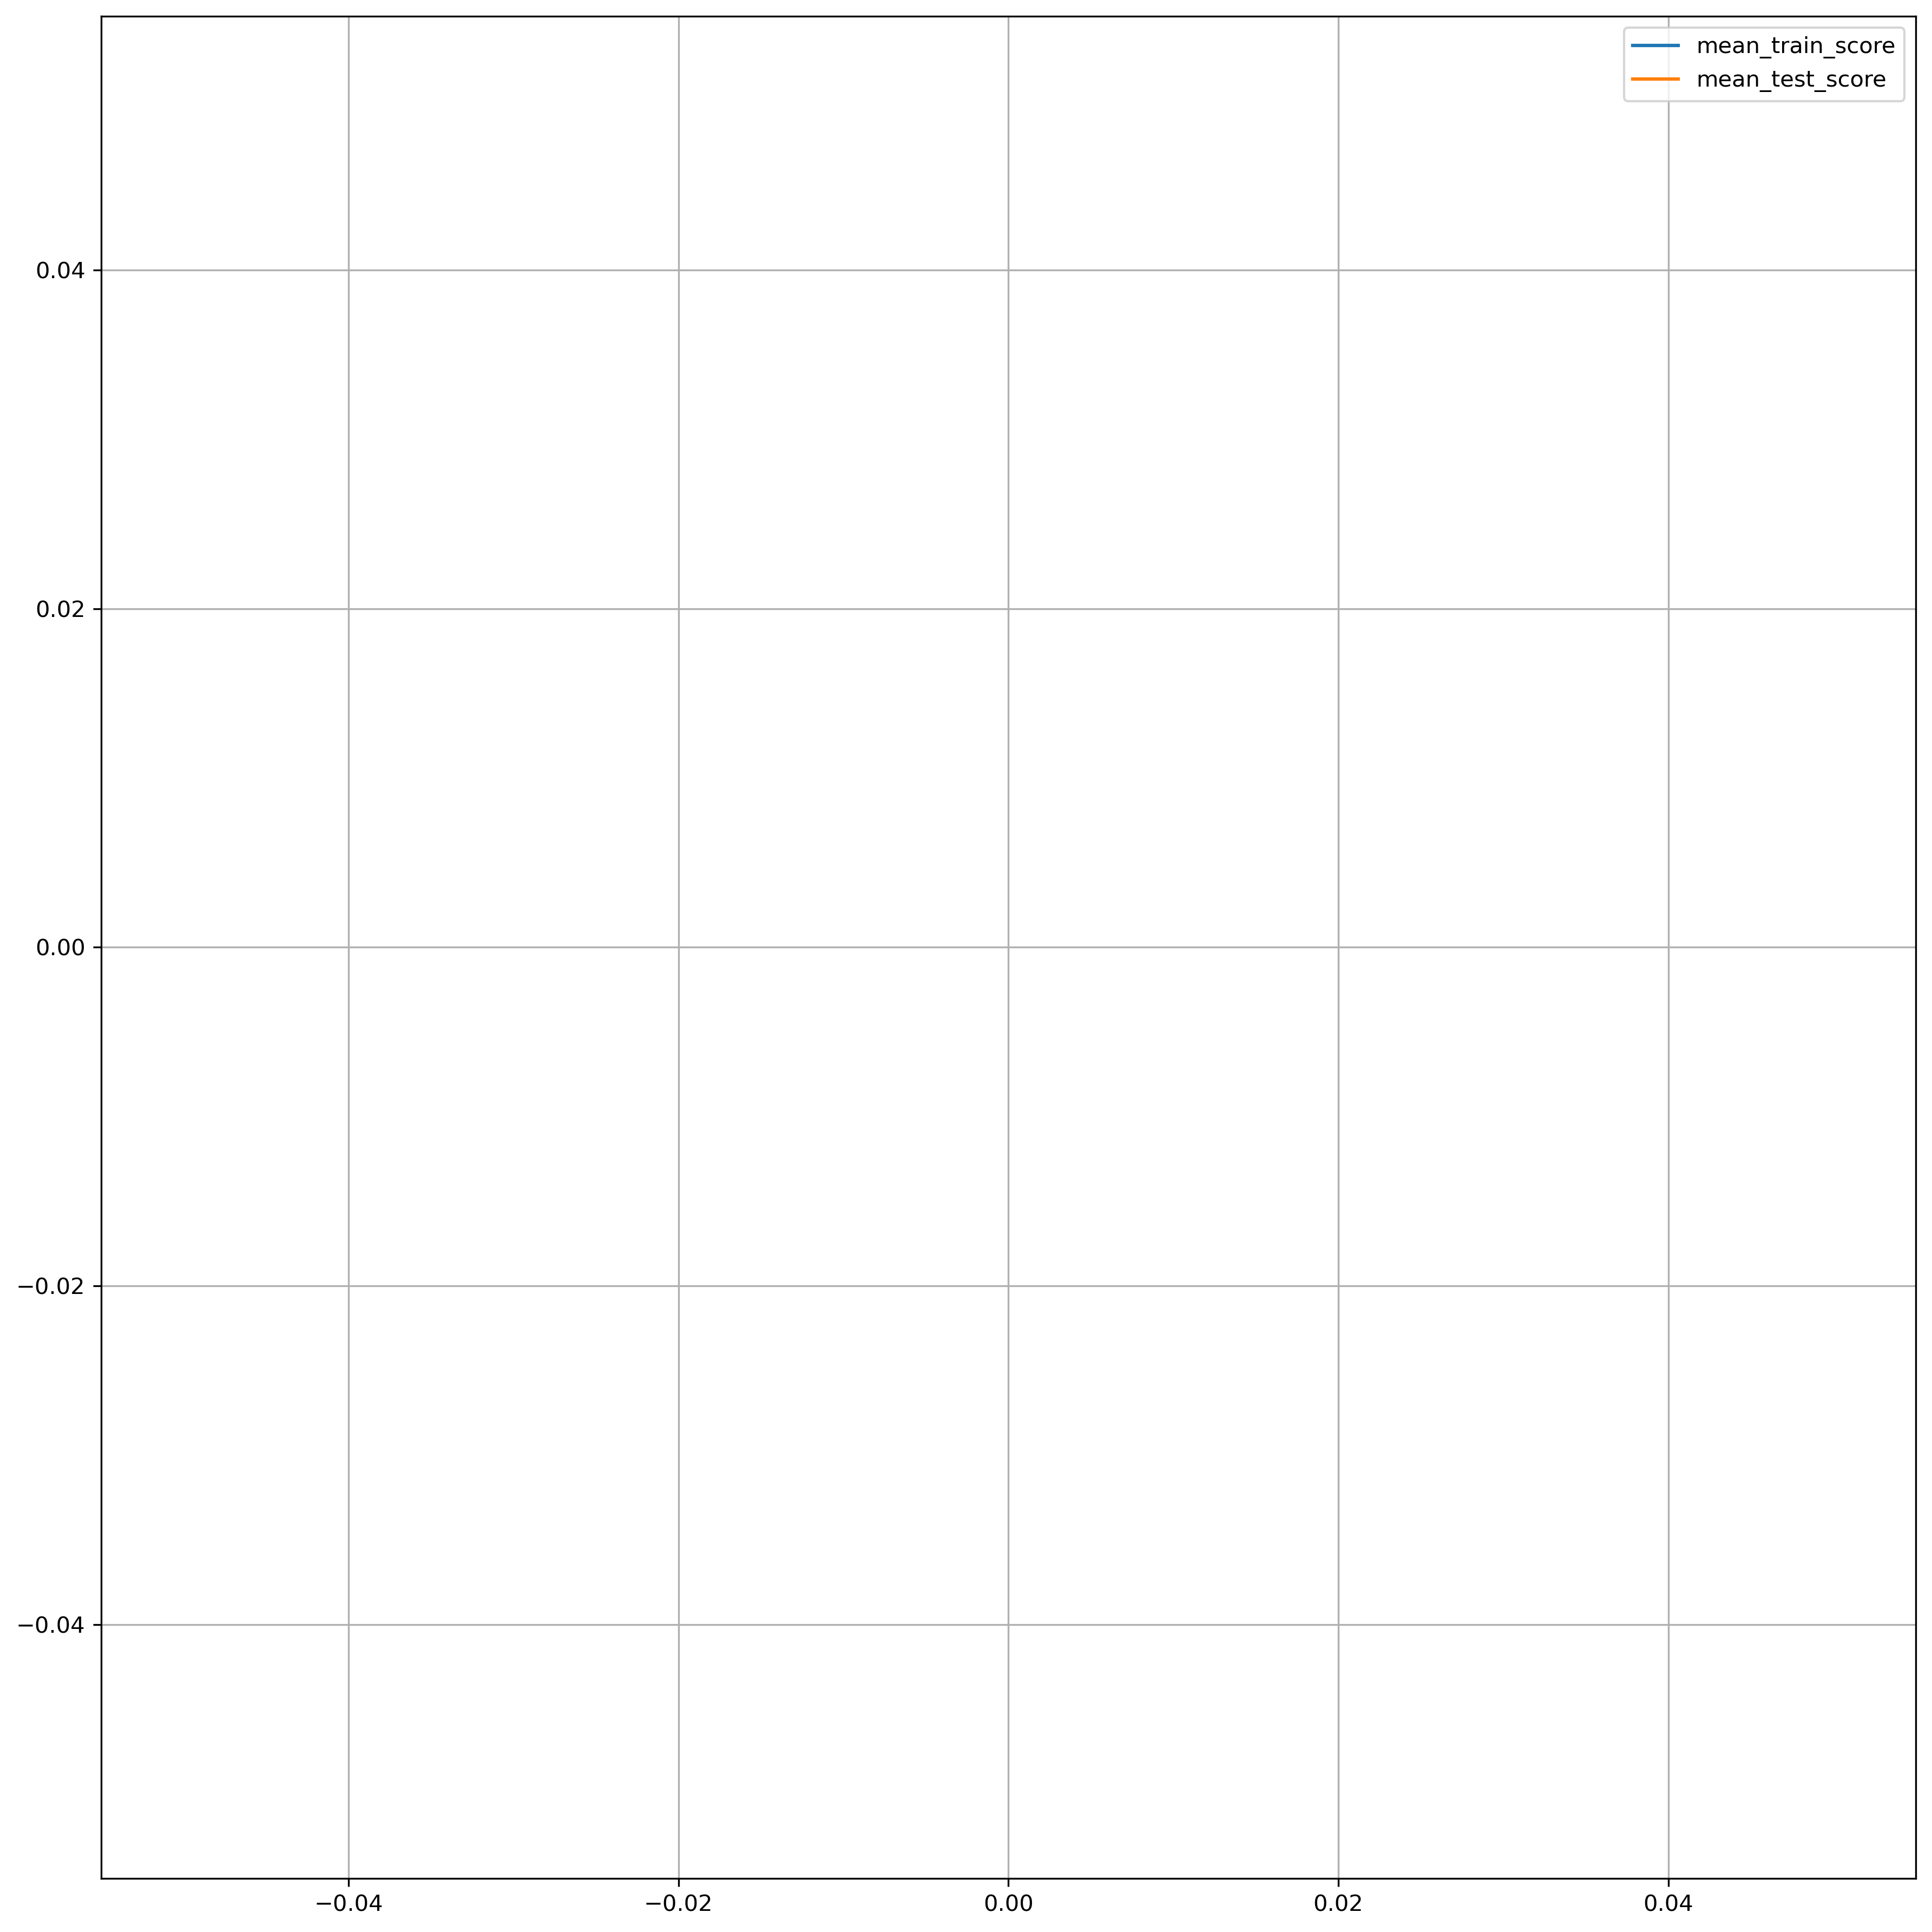

In [24]:
if lgbm_tuning:
    DisplayTuningGraph(scores)

scores